# Return to campus and infection spread

# Objective:

* **Short term:** Build a model to predict risks associated with reopening a university campus based on return-to-campus quarantine, testing protocols and efficacy of protective measures
* **Long term:** Extend model to surrounding communities

# Methods:

The prediction is an extension of the traditional SIR model commonly used in infectious disease spread. 

The input population is derived from the distribution of students by ZIP, which is (to be) translated to counties with https://simplemaps.com/data/us-zips. At this point the only COVID-19 data available is JHU county-level data, which does not report number of tests.


## SEIQRD Model

From https://github.com/jckantor/covid-19

### Nomenclature

The model describes the spread of an infectious disease based on the following parameters:

* $R_0$: Transmissability
* $\tau_{inc}$ and $\tau_{inf}$: Incubation and infectious time scales, respectively
* $\theta$: Percentage false negative when tested upon arrival
* $\omega$: Percentage of deaths in the age group of interest
* $n$: Number of undetected infectious cases
* $N$: Total number of students
* $\tau_{q,i}$, $\tau_{q,e}$, $\mu_{q}$: Start, end (days) and efficacy (%) of quarantine
* $\eta$: Percentage of infected students quarantining
* $\mu_{pm}$: efficacy (%) of protective measures


The model variables are:
* $S$: Susceptible subpopulation  of infection
* $E$: Infected but not yet infectious subpopulation
* $I$: Infectious subpopulation
* $Q$: Quarantine subpopulation
* $R$: Recovered subpopulation
* $R$: Deceased subpopulation

In the model, these variables are normalized by the population:
$$
s = \frac{S}{N},\;e=\frac{E}{N},\;i=\frac{I}{N},\;q=\frac{Q}{N},\;r=\frac{R}{N},\;d=\frac{D}{N}
$$
and 
$$
s+e+i+q+r+d=1
$$

### Equations

The evolution of the disease can be summarized as (TO BE UPDATED):
$$\text{Susceptible}
\xrightarrow{(1-u)\frac{\beta S I}{N}} 
\text{Exposed} 
\xrightarrow{\alpha E} 
\text{Infectious} 
\xrightarrow{\gamma I} 
\text{Recovered} $$
where

$$
\alpha = \frac{1}{\tau_{inc}},\;\gamma=\frac{1}{\tau_{inf}},\; \beta=\gamma R_0,\;\xi=\frac{1}{\tau_q}
$$

The system of equations reads:
\begin{align*}
\frac{ds}{dt} & = -(1-\mu)\beta s i \\
\frac{de}{dt} & = (1-\mu)\beta s i - \alpha e \\
\frac{di}{dt} & = \alpha e  - (\gamma+\zeta) i \\
\frac{dq}{dt} & = \zeta i - \xi q \\
\frac{dr}{dt} & = \gamma i + \zeta q - \omega (i+q) \\
\frac{dd}{dt} & = \omega (i+q)
\end{align*}  

### Protection measures

The return to campus includes two distinct measures:
* **Quarantine:** All out of state students are subject to a 7-day quarantine with test on day 1 and day 7
* **Aggregate Protective Measures:** After quarantine, if students are cleared by day 7 test, students are supposed to adhere to physical distancing, mask wearing and hand washing.

\begin{equation}
\mu=
\begin{cases}
0 &\mathrm{if}& t<\tau_{q,i}\\
\mu_{q} &\mathrm{if}& \tau_{q,i}\leq t<\tau_{q,e}\\
\mu_{pm} &\mathrm{if}&  t>\tau_{q,e}\\
\end{cases}
\end{equation}

### Initial conditions

* Total student population
* Number of infected students

### Testing

Whenever testing is scheduled, the simulation is paused at the time of the test plus the delay in results. At that point, a new initial condition is computed accounting for false negative and simulation continues



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from scipy.integrate import odeint









\begin{align*}
\frac{dS}{dt} & = -(1-\mu)\beta \frac{SI}{N} \\
\frac{dE}{dt} & = (1-\mu)\beta \frac{SI}{N} - \alpha E \\
\frac{dI}{dt} & = \alpha E-(1-\delta)\gamma I-\delta\varepsilon I-(1-\zeta)\gamma I-\zeta I \\
\frac{dQ}{dt} & = \zeta I - \eta Q \\
\frac{dR}{dt} & = (1-\delta)\gamma I + (1-\zeta)\gamma I + \eta Q \\
\frac{dD}{dt} & = \delta\varepsilon I
\end{align*}
\begin{equation*}
S+E+I+Q+R+D = N
\end{equation*}

In [24]:


def deriv(x, t, N0,N1,N2):
    global alpha, beta, gamma,delta,epsilon,zeta,eta
    S0, E0, I0, Q0, R0, D0, S1, E1, I1, Q1, R1, D1, S2, E2, I2, Q2, R2, D2 = x
    
    dS0dt = -(1 - mu_pop(t,0))*beta * S0 * I0 / N0 - (1-mu_cross(t,0,1))*beta * S0 * I1 / N1 - (1-mu_cross(t,0,2))*beta * S0 * I2 / N2
    dE0dt = (1 - mu_pop(t,0))*beta * S0 * I0 / N0 + (1-mu_cross(t,0,1))*beta * S0 * I1 / N1 + (1-mu_cross(t,0,2))*beta * S0 * I2 / N2 - alpha * E0
    dI0dt = alpha * E0 - (1 - delta[0]) * gamma * I0 - delta[0] * epsilon * I0 - (1 - zeta[0]) * gamma * I0 - zeta[0] * I0
    dQ0dt = zeta[0] * I0 - eta * Q0
    dR0dt = (1 - delta[0]) * gamma * I0 + (1 - zeta[0]) * gamma * I0 + eta * Q0
    dD0dt = delta[0] * epsilon * I0
    
#     dS1dt = -(1 - mu_pop(t,1))*beta * S1 * I1 / N[1]
#     dE1dt = (1 - mu_pop(t,1))*beta * S1 * I1 / N[1] - alpha * E1
#     dI1dt = alpha * E1 - (1 - delta[1]) * gamma * I1 - delta[1] * epsilon * I1 - (1 - zeta[1]) * gamma * I1 - zeta[1] * I1
#     dQ1dt = zeta[1] * I1 - eta * Q1
#     dR1dt = (1 - delta[1]) * gamma * I1 + (1 - zeta[1]) * gamma * I1 + eta * Q1
#     dD1dt = delta[1] * epsilon * I1

    dS1dt = -(1 - mu_pop(t,1))*beta * S1 * I1 / N1 - (1-mu_cross(t,0,1))*beta * S1 * I0 / N0 - (1-mu_cross(t,1,2))*beta * S1 * I2 / N2
    dE1dt = (1 - mu_pop(t,1))*beta * S1 * I1 / N1 + (1-mu_cross(t,0,1))*beta * S1 * I0 / N0 + (1-mu_cross(t,1,2))*beta * S1 * I2 / N2 - alpha * E1
    dI1dt = alpha * E1 - (1 - delta[1]) * gamma * I1 - delta[1] * epsilon * I1 - (1 - zeta[1]) * gamma * I1 - zeta[1] * I1
    dQ1dt = zeta[1] * I1 - eta * Q1
    dR1dt = (1 - delta[1]) * gamma * I1 + (1 - zeta[1]) * gamma * I1 + eta * Q1
    dD1dt = delta[1] * epsilon * I1
    
    dS2dt = -(1 - mu_pop(t,2))*beta * S2 * I2 / N2 - (1-mu_cross(t,0,2))*beta * S2 * I0 / N0 - (1-mu_cross(t,1,2))*beta * S2 * I1 / N1
    dE2dt = (1 - mu_pop(t,2))*beta * S2 * I2 / N2 + (1-mu_cross(t,0,2))*beta * S2 * I0 / N0 + (1-mu_cross(t,1,2))*beta * S2 * I1 / N1 - alpha * E2
    dI2dt = alpha * E2 - (1 - delta[2]) * gamma * I2 - delta[2] * epsilon * I2 - (1 - zeta[2]) * gamma * I2 - zeta[2] * I2
    dQ2dt = zeta[2] * I2 - eta * Q2
    dR2dt = (1 - delta[2]) * gamma * I2 + (1 - zeta[2]) * gamma * I2 + eta * Q2
    dD2dt = delta[2] * epsilon * I2
#     print(t,dS1dt+dE1dt+dI1dt+dQ1dt+dR1dt+dD1dt)
#     print(dS2dt+dE2dt+alpha * E2 - (1 - delta[2]) * gamma * I2 - delta[2] * epsilon * I2 - (1 - zeta[2]) * gamma * I2 - zeta[2] * I2)

    return dS0dt, dE0dt, dI0dt, dQ0dt, dR0dt, dD0dt, dS1dt, dE1dt, dI1dt, dQ1dt, dR1dt, dD1dt, dS2dt, dE2dt, dI2dt, dQ2dt, dR2dt, dD2dt

def forecast(t_study,N,n):
    global t_rtc, t_test_delay
    xini = np.array([N[0] - n[0], 0, n[0], 0, 0, 0, 
                     N[1] - n[1], 0, n[1], 0, 0, 0, 
                     N[2] - n[2], 0, n[2], 0, 0, 0])
    if (t_study >= t_rtc+t_test_delay):
        t = np.linspace(0,t_rtc+t_test_delay,10*(t_rtc+t_test_delay)+1)
    else:
        t = np.linspace(0,t_study,10*t_study+1)
        

    ret = odeint(deriv, xini, t, args=(N[0], N[1], N[2]))
    tsim = np.copy(t)
    S0,E0,I0,Q0,R0,D0,S1,E1,I1,Q1,R1,D1,S2,E2,I2,Q2,R2,D2 = ret.T
    if t_study > t_rtc:
        t = np.linspace(tsim[-1],t_study,10*(t_study-tsim[-1]+1))
        xini = np.array([S0[-1],E0[-1],I0[-1],Q0[-1],R0[-1],D0[-1],
                         S1[-1],E1[-1],I1[-1],Q1[-1],R1[-1],D1[-1],
                         S2[-1],E2[-1],I2[-1],Q2[-1],R2[-1],D2[-1]])
        ret = odeint(deriv, xini, t, args=(N[0], N[1], N[2]))
        tsim,S0,E0,I0,Q0,R0,D0,S1,E1,I1,Q1,R1,D1,S2,E2,I2,Q2,R2,D2 = \
          merge(tsim,S0,E0,I0,Q0,R0,D0,S1,E1,I1,Q1,R1,D1,S2,E2,I2,Q2,R2,D2,t,ret)
    return tsim,S0,E0,I0,Q0,R0,D0,S1,E1,I1,Q1,R1,D1,S2,E2,I2,Q2,R2,D2
def merge(tsim,S0,E0,I0,Q0,R0,D0,S1,E1,I1,Q1,R1,D1,S2,E2,I2,Q2,R2,D2,t,ret):
    tsim = np.append(tsim,t)
    S0n,E0n,I0n,Q0n,R0n,D0n,
    S1n,E1n,I1n,Q1n,R1n,D1n,
    S2n,E2n,I2n,Q2n,R2n,D2n = ret.T
    S0 = np.append(S0,S0n)
    E0 = np.append(E0,E0n)
    I0 = np.append(I0,I0n)
    Q0 = np.append(Q0,Q0n)
    R0 = np.append(R0,R0n)
    D0 = np.append(D0,D0n)
    S1 = np.append(S1,S1n)
    E1 = np.append(E1,E1n)
    I1 = np.append(I1,I1n)
    Q1 = np.append(Q1,Q1n)
    R1 = np.append(R1,R1n)
    D1 = np.append(D1,D1n)
    S2 = np.append(S2,S2n)
    E2 = np.append(E2,E2n)
    I2 = np.append(I2,I2n)
    Q2 = np.append(Q2,Q2n)
    R2 = np.append(R2,R2n)
    D2 = np.append(D2,D2n)
    return tsim,S0,E0,I0,Q0,R0,D0,S1,E1,I1,Q1,R1,D1,S2,E2,I2,Q2,R2,D2

In [25]:
def plotseiqrd(t, S, E, I, Q, R,D,yscale='linear',ylim0=0):
    f, ax = plt.subplots(1,1,figsize=(10,4))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, Q, 'C1', alpha=0.7, linewidth=2, label='Quarantined')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+Q+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.set_yscale(yscale)
    ax.grid(b=True, which='both', c='w', lw=2, ls='-')
    legend = ax.legend(borderpad=2.0)
    legend.get_frame().set_alpha(0.5)
#     for spine in ('top', 'right', 'bottom', 'left'):
#         ax.spines[spine].set_visible(False)
#   if L is not None:
#       plt.title("Lockdown after {} days".format(L))
#   plt.show();

#   if R0 is not None or CFR is not None:
#     f = plt.figure(figsize=(12,4))
  
#   if R0 is not None:
#     # sp1
#     ax1 = f.add_subplot(121)
#     ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

#     ax1.set_xlabel('Time (days)')
#     ax1.title.set_text('R_0 over time')
#     # ax.set_ylabel('Number (1000s)')
#     # ax.set_ylim(0,1.2)
#     ax1.yaxis.set_tick_params(length=0)
#     ax1.xaxis.set_tick_params(length=0)
#     ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
#     legend = ax1.legend()
#     legend.get_frame().set_alpha(0.5)
#     for spine in ('top', 'right', 'bottom', 'left'):
#       ax.spines[spine].set_visible(False)

#   if Alpha is not None:
#     # sp2
#     ax2 = f.add_subplot(122)
#     ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

#     ax2.set_xlabel('Time (days)')
#     ax2.title.set_text('fatality rate over time')
#     # ax.set_ylabel('Number (1000s)')
#     # ax.set_ylim(0,1.2)
#     ax2.yaxis.set_tick_params(length=0)
#     ax2.xaxis.set_tick_params(length=0)
#     ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
#     legend = ax2.legend()
#     legend.get_frame().set_alpha(0.5)
#     for spine in ('top', 'right', 'bottom', 'left'):
#       ax.spines[spine].set_visible(False)

    plt.show();

In [33]:
Npopulations = 3
i_s_0 = 0; i_s_1 = 1; i_ocom = 2 
delta = np.array([0.01,0.01,0.2]) #mortality rates by population
R0 = 5.00 # nominal R_0
t_death = 9 #days to death
epsilon = 1/t_death
t_quarantine = 14 # duration of quarantine for COVID-19 patients
t_test_delay = 3 # test result delay
zeta = np.array([0.4,0.4,0.6]) #Probability that COVID-19 patients follow quarantine protocol
mu_rtc_ovt = 0.0 #efficacy of return to campus protocol of out of staters
mu_transition_rtc = 0. #efficacy for transition off RTC protocol caused by test delay
mu_pm_st = 0.0 #efficacy of protective measures for students
mu_pm_com = 0.0 #efficacy of protective measures of community (other than students)
mu_quarantine = 0.0 #efficacy of quarantine of COVID-19
rho = 0.3 #fraction of false negative
mu_cross_ = np.zeros((Npopulations,Npopulations))
mu_cross_[0,1] = 0.6
mu_cross_[0,2] = 0.9
mu_cross_[1,2] = 0.9
def mu_cross(t,j,k):
    global mu_cross_, mu_pm_st,mu_rtc_ovt,t_rtc,t_test_delay,mu_transition_rtc,mu_pm_com,mu_quarantine
      
    mu = mu_cross_[j,k]
    return mu
t_rtc = 7 # duration of return to campus protocol
t_class_start = 14 # when classes start from beginning of simulation


incubation_time = 5.1
infection_time = 3.3
alpha = 1 / incubation_time
gamma = 1 / infection_time
beta = gamma * R0
eta = 1 / t_quarantine



def mu_pop(t,k):
    global mu_pm_st,mu_rtc_ovt,t_rtc,t_test_delay,mu_transition_rtc,mu_pm_com,mu_quarantine
    if k == 0:  # in state students (do not follow RTC protocol)
        mu = mu_pm_st
    if k == 1:
        if (t < t_rtc):
            mu = mu_rtc_ovt
        elif (t >= t_rtc) and (t < t_rtc+t_test_delay):
            mu = mu_transition_rtc
        else:
            mu = mu_pm_st
    if k == 2:
        mu = mu_pm_com
    return mu


N = np.array([3000,10000,30000])
n = np.array([10,10,10])
tsim,S0,E0,I0,Q0,R0,D0,S1,E1,I1,Q1,R1,D1,S2,E2,I2,Q2,R2,D2 = forecast(2,N,n)

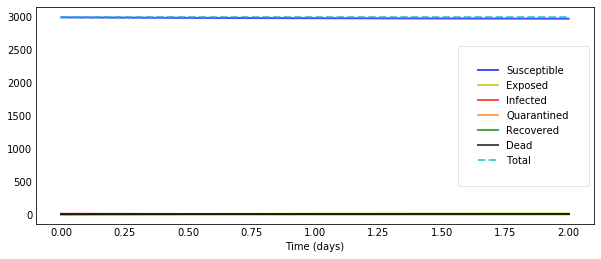

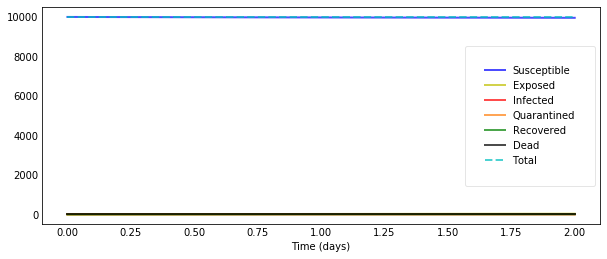

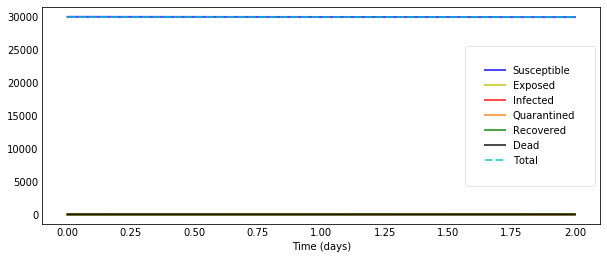

In [34]:
plotseiqrd(tsim,S0,E0,I0,Q0,R0,D0,'linear',0)
plotseiqrd(tsim,S1,E1,I1,Q1,R1,D1,'linear',0)
plotseiqrd(tsim,S2,E2,I2,Q2,R2,D2,'linear',0)
# plotseiqrd(tsim,S0,E0,I0,Q0,R0,D0,'log',1)
# plotseiqrd(tsim,S1,E1,I1,Q1,R1,D1,'log',1)
# plotseiqrd(tsim,S2,E2,I2,Q2,R2,D2,'log',1)

In [30]:
N[0]-(S0[-1] + E0[-1] + I0[-1] + Q0[-1] + R0[-1] + D0[-1])

2.2737367544323206e-12

In [26]:
N[1]-(S1[-1] + E1[-1] + I1[-1] + Q1[-1] + R1[-1] + D1[-1])

-2.7284841053187847e-12

In [27]:
N[2]-(S2[-1] + E2[-1] + I2[-1] + Q2[-1] + R2[-1] + D2[-1])

7.275957614183426e-12

In [ ]:
# SEIQR model differential equations.
def deriv(x, t, ucoef,Npopulations):
    global alpha,beta,gamma,xi,zeta,omega
    
    for k in Npopulations:
        s, e, i, q, r, d = x
        ds
    dsdt = -(1-mucoef*mu_step(t,ipop))*beta * s * i
    dedt =  (1-mucoef*mu_step(t,ipop))*beta * s * i - alpha * e
    didt = alpha * e - (gamma+xi) * i
    dqdt = xi*i - zeta*q
    drdt = gamma * i + zeta*q - omega * r
    dddt = omega*r
    return [dsdt, dedt, didt, dqdt, drdt,ddt]

def seiqr(tstart,tend,xini,ucoef, ipop, alpha, beta, gamma,xi,zeta,omega):
    t = np.linspace(tstart, tend, tend - tsart +1)
    s, e, i, q, r = odeint(deriv, x_initial, t, args=(1, alpha, beta, gamma,xi,zeta,omega)).T
    return t, s, e, i, q, r, d

def mu_step(t,ipop):
    global t_rtc, mu_rtc, t_test_delay
    if  (t < t_rtc):
        mustep = mu_rtc[ipop]
    elif (t >= t_rtc) and (t < t_rtc + t_test_delay):
        mustep = mu_test_delay[ipop]
    else:
        mustep = mu_pm[ipop]
    return mustep

In [ ]:
S0 = np.copy(population_size)
E0 = 

In [ ]:


class Population:
    def __init__(self,R0,t_incubation,t_infective,theta_fasle_negative,
                 eta,t_infected_quarantine,
                 u_quarantine,u_transition,u_pm,ucoef):
        self.alpha = 1/t_incubation
        self.gamma = 1/t_infective
        self.beta = R0/t_infective
        self.theta = zeta_fasle_negative
        self.zeta = 1/t_infected_quarantine
        self.eta = eta
        self.t_end_rtc_q = t_end_rtc_quarantine
        self.u_q = u_quarantine
        self.u_pm = u_pm
        self.ucoef = ucoef
        self.t = np.array([])
        self.s = np.array([])
        self.e = np.array([])
        self.i = np.array([])
        self.q = np.array([])
        self.r = np.array([])
        self.d = np.array([])
    def u_step(t):
        if (t < t_end_rtc_quarantine):
            ustep = u_quaratine
        else:
            ustep = u_pm
        return ustep
    def deriv(x, t, ucoef, alpha, beta, gamma,eta,zeta):
        s, e, i, q, r = x
        dsdt = -(1-ucoef*u_step(t)/100)*beta * s * i
        dedt =  (1-ucoef*u_step(t)/100)*beta * s * i - alpha * e
        didt = alpha * e - (gamma+eta) * i
        dqdt = eta*i - zeta*q
        drdt =  gamma * i + zeta*q
        return [dsdt, dedt, didt, dqdt, drdt]

    def seiqr(tstart,tend,xini,ucoef, alpha, beta, gamma,eta,zeta):
        t = np.linspace(tstart, tend, tend - tsart +1)
        s, e, i, q, r = odeint(deriv, x_initial, t, args=(1, alpha, beta, gamma,eta,zeta)).T
        return t, s, e, i, q, r


In [ ]:
R0 = 2.4 
t_incubation = 5.1 #days
t_infective = 3.3 #days
# N = Total_students 
Total_students = 10000
Total_infected = 10
false_negative_tests = 10 # %

print(n,N)
t_quarantine_i = 0  # day
t_test_i = 0
t_quarantine_e = 7
t_test_e = 2
u_quaratine = 80 # % efficacy of quarantine
u_transition = 40 # % efficacy of quarantine-PM transition while waiting for test
u_pm = 0 # % efficacy of protective measures
t_study = 140 # days
t_q = 7
eta = 1 # % symptomatic infected that quarantine

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma
eta /= 100.
zeta = 1/t_q

# step function of protective measure
def u_step(t):
    if t < t_quarantine_i:
        ustep = 0
    elif (t >=  t_quarantine_i) and (t < t_quarantine_e):
        ustep = u_quaratine
    elif (t >= t_quarantine_e) and (t < t_quarantine_e + t_test_e):
        ustep = u_transition
    else:
        ustep = u_pm
    return ustep

# SEIQR model differential equations.
def deriv(x, t, ucoef, alpha, beta, gamma,eta,zeta):
    s, e, i, q, r = x
    dsdt = -(1-ucoef*u_step(t)/100)*beta * s * i
    dedt =  (1-ucoef*u_step(t)/100)*beta * s * i - alpha * e
    didt = alpha * e - (gamma+eta) * i
    dqdt = eta*i - zeta*q
    drdt =  gamma * i + zeta*q
    return [dsdt, dedt, didt, dqdt, drdt]

def seiqr(tstart,tend,xini,ucoef, alpha, beta, gamma,eta,zeta):
    t = np.linspace(tstart, tend, tend - tsart +1)
    s, e, i, q, r = odeint(deriv, x_initial, t, args=(1, alpha, beta, gamma,eta,zeta)).T
    return t, s, e, i, q, r

def appendtimeseries(t, s, e, i, q, r, t1, s1, e1, i1, q1, r1):
    t = np.append(t,t1)
    s = np.append(s,s1)
    e = np.append(e,e1)
    i = np.append(i,i1)
    q = np.append(q,q1)
    r = np.append(r,r1)
    return t, s, e, i, q, r

if t_test_i == 0:
    # initial number of infected and recovered individuals
    
    e_initial = round(Total_infected*false_negative_tests/100)/N
    i_initial = 0.00
    r_initial = 0.00
    q_initial = Total_infected/N - e_initial
    s_initial = 1 - e_initial - i_initial - q_initial - r_initial
    x_initial = s_initial, e_initial, i_initial, q_initial, r_initial
    t = np.linspace(0, t_quarantine_e, t_quarantine_e+1)
    t_tot = np.copy(t)
    s, e, i, q, r = odeint(deriv, x_initial, t, args=(1, alpha, beta, gamma,eta,zeta)).T
if t_test_i > 0:
    e_initial = Total_infected/N
    i_initial = 0.00
    r_initial = 0.00
    q_initial = 0.000
    s_initial = 1 - e_initial - i_initial - q_initial - r_initial
    x_initial = s_initial, e_initial, i_initial, q_initial, r_initial
    t = np.linspace(0, t_test_i, t_test_i+1)
    t_tot = np.copy(t)
    s, e, i, q, r = odeint(deriv, x_initial, t, args=(1, alpha, beta, gamma,eta,zeta)).T
    print(i)
    E = round(e[-1]*N); I = round(i[-1]*N); R = round(r[-1]*N)
    E_false = round(E*false_negative_tests/100)
    I_false = round(I*false_negative_tests/100)
    Q = round(q[-1]*N)
    Q += (E-E_false) + (I-I_false)
    e_initial = E_false/N
    i_initial = I_false/N
    q_initial = Q/N
    r_initial = R/N
    s_initial = 1 - e_initial - i_initial - q_initial - r_initial
    x_initial = s_initial, e_initial, i_initial, q_initial, r_initial
    t = np.linspace(t_test_i,t_quarantine_e, t_quarantine_e-t_test_i+1)
    t_tot = np.append(t_tot,t)
    s_q, e_q, i_q, q_q, r_q = odeint(deriv, x_initial, t, args=(1, alpha, beta, gamma,eta,zeta)).T
    s = np.append(s,s_q); r = np.append(r,r_q); e = np.append(e,e_q); i = np.append(i,i_q); q = np.append(q,q_q)
    print(i,i_q)
t = np.linspace(t_quarantine_e, t_quarantine_e + t_test_e, t_test_e+1)
t_tot = np.append(t_tot,t)
x_initial = s[-1], e[-1], i[-1], q[-1], r[-1]
s_q, e_q, i_q, q_q, r_q = odeint(deriv, x_initial, t, args=(1, alpha, beta, gamma,eta,zeta)).T
s = np.append(s,s_q); r = np.append(r,r_q); e = np.append(e,e_q); i = np.append(i,i_q); q = np.append(q,q_q)
E = round(e[-1]*N); I = round(i[-1]*N); R = round(r[-1]*N)
E_false = round(E*false_negative_tests/100)
I_false = round(I*false_negative_tests/100)
Q = round(q[-1]*N)
Q += (E-E_false) + (I-I_false)
e_initial = E_false/N
i_initial = I_false/N
q_initial = Q/N
r_initial = R/N
s_initial = 1 - e_initial - i_initial - q_initial - r_initial
x_initial = s_initial, e_initial, i_initial, q_initial, r_initial
t = np.linspace(t_quarantine_e + t_test_e, t_study, t_study-(t_quarantine_e+t_test_e)+1)
t_tot = np.append(t_tot,t)
x_initial = s[-1], e[-1], i[-1], q[-1], r[-1]
s_q, e_q, i_q, q_q, r_q = odeint(deriv, x_initial, t, args=(1, alpha, beta, gamma,eta,zeta)).T
s = np.append(s,s_q); r = np.append(r,r_q); e = np.append(e,e_q); i = np.append(i,i_q); q = np.append(q,q_q)


e_initial = round(Total_infected*false_negative_tests/100)/N
i_initial = 0.00
q_initial = 0.00
r_initial = Total_infected/N - e_initial
s_initial = 1 - e_initial - i_initial - q_initial - r_initial
x_initial = s_initial, e_initial, i_initial, q_initial, r_initial
t = np.linspace(0, t_study, t_study+1)
s0, e0, i0, q0, r0 = odeint(deriv, x_initial, t, args=(0, alpha, beta, gamma, eta, zeta)).T
"""
At t_quarantine_e+t_test_result_e, 
the 1-false_negative_tests fraction of E and I goes to R, 
the rest is allowed to continue
"""

# plot the data
fig = plt.figure(figsize=(12, 10))
ax = [fig.add_subplot(311, axisbelow=True), 
      fig.add_subplot(312)]

pal = sns.color_palette()

ax[0].stackplot(t_tot/7, N*s, N*e, N*i, N*q, N*r, colors=pal, alpha=0.6)
ax[0].set_title('Susceptible and Recovered Populations with {0:3.0f}% Effective Protective Measures'.format(u_pm))
ax[0].set_xlabel('Weeks following Initial Campus Exposure')
ax[0].set_xlim(0, t_tot[-1]/7)
ax[0].set_ylim(0, N)
ax[0].legend([
    'Susceptible', 
    'Exposed/no symptoms', 
    'Infectious/symptomatic',
    'Quarantine',
    'Recovered'], 
    loc='best')
ax[0].plot(np.array([t_quarantine_i/7, t_quarantine_i/7]), ax[0].get_ylim(), 'r', lw=3)
ax[0].plot(np.array([t_quarantine_e/7, t_quarantine_e/7]), ax[0].get_ylim(), 'r', lw=3)
ax[0].plot(np.array([0, t[-1]])/7, [N/R0, N/R0], lw=3, label='herd immunity')
ax[0].annotate("Start of Quarantine",
    (t_quarantine_i/7, 0), (t_quarantine_i/7 + 1.5, N/5),
    arrowprops=dict(arrowstyle='->'))
ax[0].annotate("End of Quarantine",
    (t_quarantine_e/7, 0), (t_quarantine_e/7 + 1.5, N/10),
    arrowprops=dict(arrowstyle='->'))
ax[0].annotate("Herd Immunity without Protective Measure",
    (t[-1]/7, N/R0), (t[-1]/7 - 8, N/R0 - N/5),
    arrowprops=dict(arrowstyle='->'))

ax[1].stackplot(t/7, N*i0,N*e0,N*q0, colors=pal[3:0:-1], alpha=0.5)
ax[1].stackplot(t_tot/7, N*i, N*e,N*q, colors=pal[3:0:-1], alpha=0.5)
ax[1].set_title('Infected Population with no Protecive Measure and with {0:3.0f}% Effective Protective Measures'.format(u_pm))
ax[1].set_xlim(0, t_tot[-1]/7)
ax[1].set_ylim(0, max(0.3*N, 1.05*max(N*(e + i))))
ax[1].set_xlabel('Weeks following Initial Campus Exposure')
ax[1].legend([
    'Infective/Symptomatic', 
    'Exposed/Not Sympotomatic',
    'Quarantine'],
    loc='upper right')
ax[1].plot(np.array([t_quarantine_i/7, t_quarantine_i/7]), ax[0].get_ylim(), 'r', lw=3)
ax[1].plot(np.array([t_quarantine_e/7, t_quarantine_e/7]), ax[0].get_ylim(), 'r', lw=3)

y0 = N*(e0 + i0)
k0 = np.argmax(y0)
ax[1].annotate("No protective measure", (t[k0]/7, y0[k0] + 100))

y = N*(e + i)
k = np.argmax(y)
ax[1].annotate("With {0:3.0f}% effective protective measures ".format(u_pm), (t[k]/7, y[k] + 100))

for a in ax:
    a.xaxis.set_major_locator(plt.MultipleLocator(5))
    a.xaxis.set_minor_locator(plt.MultipleLocator(1))
    a.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    a.grid(True)

plt.tight_layout()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from scipy.integrate import odeint
import seaborn as sns
filenamebase = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"

In [ ]:
today = date.today()
iday = today.day - 9
ddate = date.today()

states = ['Vermont', 'Maine', 'New Jersey', 'New York', 'New Hampshire', 'Massachusetts']
n = 0
while iday <= today.day - 1:
#     if (n == 0):
#         incidence_old = incidence.copy()
    ddate = ddate.replace(day = iday)
    filename = filenamebase+ddate.strftime("%m-%d-%Y") + ".csv"
    print(filename)
    df = pd.read_csv(filename)
    df_US_all = df[df['Country_Region'] == 'US']
    df_US = df_US_all[df_US_all['Admin2'] != 'Unassigned']
    incidence = df_US.pivot_table(index = ['Province_State', 'Admin2'], values = 'Incidence_Rate')
#     print(confirmed)
    if (n == 0):
        covid = incidence.copy()
        covid['Incidence_Rate'][:] = 0.
    if (n > 0):
        for ind in covid.index:
            if ind in incidence.index:
                covid['Incidence_Rate'][ind] += incidence['Incidence_Rate'][ind] # - incidence_old['Incidence_Rate'][ind]
    iday += 1
    n += 1
covid['Incidence_Rate'][:] /= n-1
# confirmed["Confirmed"]["Vermont","Orleans"]  

# d1 = today.strftime("%m-%d-%Y")
# print("d1 =", d1)
# # df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/08-11-2020.csv")
# df_US = df[df['Country_Region'] == 'US']
# df_US

In [ ]:
df_US.columns

In [ ]:
covid['Returning_Students'] = np.random.randint(0, 200, covid.shape[0])
Total_students = 0
for i in covid.index:
    if i[0] in states:
        print(i,covid['Returning_Students'][i])
        Total_students += covid['Returning_Students'][i]
print('Total_students: ',Total_students)

In [ ]:
# Create a distribution 
print(Total_students)

In [ ]:
for i in covid.index:
    if i[0] in states:
        print(i,covid['Returning_Students'][i],covid['Incidence_Rate'][i]/100000)

In [ ]:
covid['Infected_Students'] = round(covid['Returning_Students'] * covid['Incidence_Rate']/10000*0.1)

In [ ]:
Total_infected = 0
for i in covid.index:
    if i[0] in states:
        Total_infected += covid['Infected_Students'][i]
print(Total_infected)

In [ ]:
print(i_q)